In [0]:
import pandas as pd

In [0]:
# If on google chrome, upload the file here.
# from google.colab import files
# import io
# all_games_info = pd.read_csv(io.StringIO(files.upload()["all_game_info.csv"].decode("utf-8")))

In [0]:
# If on firefox or google chrome, open the sidebar, go to "files" tab, and upload there.
all_games_info = pd.read_csv("all_game_info.csv")

In [0]:
def setup_train_test(games_info: pd.core.frame.DataFrame):
    if games_info is None:
        raise ValueError("Please pass the pandas dataframe")
        
    atts_to_exclude = ['home','away','game_name']
    atts_to_exclude += [col for col in games_info.columns.values if "PM" in col]

    train_df = games_info.sample(frac=0.8,random_state=200)    # split into training and testing
    test_df = games_info.drop(train_df.index)

    x_train = train_df.drop(['away_points','home_points']+atts_to_exclude,axis=1)
    x_test = test_df.drop(['away_points','home_points']+atts_to_exclude,axis=1)
    y_train_home = train_df['home_points']
    y_train_away = train_df['away_points']
    
    return (x_train, x_test, y_train_home, y_train_away, test_df)

In [0]:
import xgboost as xgb
def generate_classifiers(x_train, x_test, y_train_home, y_train_away):
    home_classifier = xgb.XGBClassifier(n_estimators = 300, n_jobs = -1, verbosity = 0, learning_rate = 0.05)
    away_classifier = xgb.XGBClassifier(n_estimators = 300, n_jobs = -1, verbosity = 0, learning_rate = 0.05)
    
    home_classifier.fit(x_train, y_train_home)
    away_classifier.fit(x_train, y_train_away)
    
    return (home_classifier, away_classifier)

In [0]:
def generate_results(games_info, home_predictions, away_predictions):
    def calculate_loss(results_dict: dict):
        for stats in results_dict.values():
            stats["home_loss"] = (stats["home_points_predicted"] -
                                     stats["home_points_actual"])
            stats["away_loss"] = (stats["away_points_predicted"] -
                                     stats["away_points_actual"])

    results = pd.DataFrame({'game_name': games_info.game_name,
                        'home_points_predicted': home_predictions,
                        'away_points_predicted': away_predictions,
                        'home_points_actual': games_info.home_points,
                        'away_points_actual': games_info.away_points})
    results_dict = results.to_dict("index")
    calculate_loss(results_dict)
    results = pd.DataFrame(results_dict).transpose()
    
    return results.sort_values(by=["game_name"])[["game_name",
                                              "home_points_predicted",
                                              "home_points_actual",
                                              "home_loss",
                                              "away_points_predicted",
                                              "away_points_actual",
                                              "away_loss"]]

In [0]:
x_train, x_test, y_train_home, y_train_away, test_df = setup_train_test(all_games_info)
h_classifier, a_classifier = generate_classifiers(x_train, x_test, y_train_home, y_train_away)

In [0]:
h_predictions = h_classifier.predict(x_test)
a_predictions = a_classifier.predict(x_test)
results = generate_results(test_df, h_predictions, a_predictions)

In [0]:
import matplotlib.pyplot as plt
from statistics import mean
import numpy as np
def graph_scores(results, side: str = "home"):
    if side != "home" and side != "away":
        raise ValueError("Please select either 'home' or 'away'")
    plt.scatter(results["game_name"], results[side + "_loss"])
    plt.xlabel("games")
    plt.ylabel(side + " loss")
    plt.title(side + " loss vs games")
    plt.tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False
    )
    plt.axhline(y=0, color='r')
    plt.tight_layout()
    plt.show()

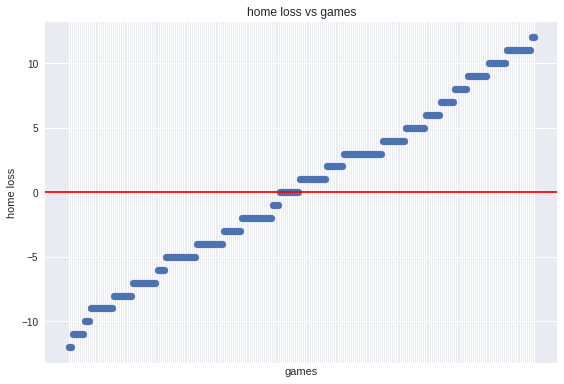

In [128]:
graph_scores(results.sort_values(by=["home_loss"])[int(.2*len(results)):int(.8*len(results))], side="home")

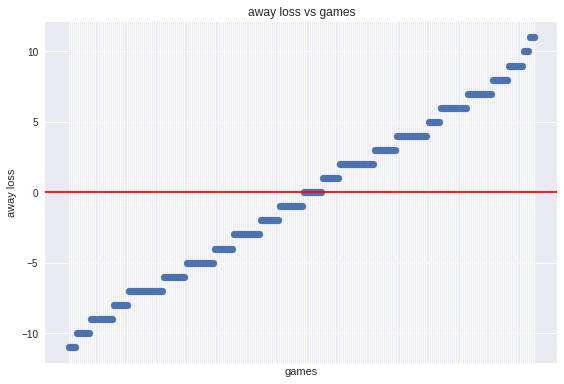

In [127]:
graph_scores(results.sort_values(by=["away_loss"])[int(.2*len(results)):int(.8*len(results))], side="away")

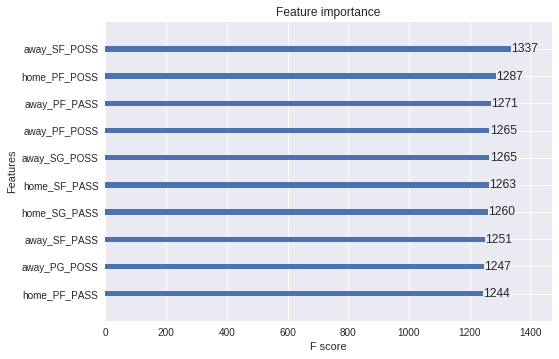

In [57]:
xgb.plot_importance(a_classifier, max_num_features=10)

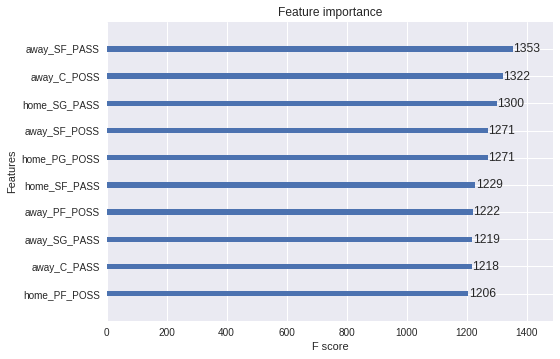

In [58]:
xgb.plot_importance(h_classifier, max_num_features=10)

In [109]:
from sklearn.metrics import mean_absolute_error
print(mean(results["home_loss"]))
print(mean(results["away_loss"]))
print(mean_absolute_error(results["home_points_actual"], results["home_points_predicted"]))
print(mean_absolute_error(results["away_points_actual"], results["away_points_predicted"]))

-1.0053050397877985
0.7029177718832891
10.915119363395226
11.153846153846153


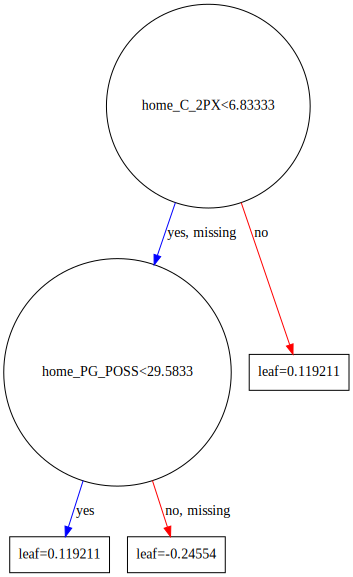

In [67]:
xgb.to_graphviz(h_classifier, num_trees=1)

In [0]:
# _classifier.get_params()
h_classifier.get_booster().dump_model('trees.txt')